In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
state_dim = 36
action_dim = 2
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
BATCH_SIZE = 32

In [3]:
def load_model():
    model = torch.load('diamant_model.pth')
    model.eval()  # Set le model en mode evaluation
    return model

In [4]:
# Classe global du jeu
class DiamantGame:
    def __init__(self):
        self.reset()

    # Fonction d'initialisation du jeu
    def reset(self,nbr_joueurs = 3):
        self.diamonds_collected = 0
        self.cards_played = []
        self.is_game_over = False
        self.deck = [
            {
                "type": "Trésor",
                "value": 3
            },
            {
                "type": "Trésor",
                "value": 4
            },
            {
                "type": "Trésor",
                "value": 14
            },
            {
                "type": "Trésor",
                "value": 13
            },
            {
                "type": "Trésor",
                "value": 2
            },
            {
                "type": "Trésor",
                "value": 15
            },
            {
                "type": "Trésor",
                "value": 17
            },
            {
                "type": "Trésor",
                "value": 7
            },
            {
                "type": "Trésor",
                "value": 9
            },
            {
                "type": "Trésor",
                "value": 1
            },
            {
                "type": "Trésor",
                "value": 5
            },
            {
                "type": "Trésor",
                "value": 11
            },
            {
                "type": "Trésor",
                "value": 11
            },
            {
                "type": "Trésor",
                "value": 5
            },
            {
                "type": "Trésor",
                "value": 7
            },
            {
                "type": "Relique",
                "value": 7
            },
            {
                "type": "Relique",
                "value": 5
            },
            {
                "type": "Relique",
                "value": 8
            },
            {
                "type": "Relique",
                "value": 10
            },
            {
                "type": "Relique",
                "value": 12
            },
            {
                "type": "Danger",
                "value": "Araignée"
            },
            {
                "type": "Danger",
                "value": "Araignée"
            },
            {
                "type": "Danger",
                "value": "Araignée"
            },
            {
                "type": "Danger",
                "value": "Lave"
            },
            {
                "type": "Danger",
                "value": "Lave"
            },
            {
                "type": "Danger",
                "value": "Lave"
            },
            {
                "type": "Danger",
                "value": "Pierre"
            },
            {
                "type": "Danger",
                "value": "Pierre"
            },
            {
                "type": "Danger",
                "value": "Pierre"
            },
            {
                "type": "Danger",
                "value": "Serpent"
            },
            {
                "type": "Danger",
                "value": "Serpent"
            },
            {
                "type": "Danger",
                "value": "Serpent"
            },
            {
                "type": "Danger",
                "value": "Pique"
            },
            {
                "type": "Danger",
                "value": "Pique"
            },
            {
                "type": "Danger",
                "value": "Pique"
            },
        ]
        self.nbr_joueurs = nbr_joueurs
        self.last_action = 0

    # Fonction permettant de piocher une carte
    def draw_card(self):
        card = random.choice(self.deck)
        self.deck.remove(card)
        return card
    
    # Fonction permettant de définir les rewards en fonction de l'action
    def play_turn(self, action):

        reward = 0

        self.last_action = action

        if action == 1:
            self.is_game_over = True
            if self.diamonds_collected == 0:
                reward = -15
            elif self.diamonds_collected < 4:
                reward = -2
            else:
                reward = self.diamonds_collected   # Reward for leaving safely
            return self.diamonds_collected, reward, self.is_game_over

        reward = 10
        card = self.draw_card()
        self.cards_played.append(card)

        card_value = card['value']
        card_type = card['type']

        if card_type == 'Trésor':
            self.diamonds_collected += card_value  # Reward for collecting diamonds
        elif card_type == 'Relique':
            self.diamonds_collected += 1
        elif card_type == 'Danger':
            dangerAlreadyExist = False
            for card in self.cards_played:
                if card['type'] == 'Danger':
                    if card['value'] == card_value:
                        dangerAlreadyExist = True
            if dangerAlreadyExist:
                self.is_game_over = True
                self.diamonds_collected = -5
                reward = -15

        return self.diamonds_collected, reward, self.is_game_over

    # Fonction permettant de récupérer l'état du jeu
    def get_state(self):
        state = [0 if self.last_action == 0 else self.diamonds_collected]
        for card in self.cards_played:
            if card['type'] == 'Trésor':
                state.append(1)
            elif card['type'] == 'Relique':
                state.append(7)
            elif card['type'] == 'Danger':
                if card['value'] == 'Araignée':
                    state.append(2)
                elif card['value'] == 'Lave':
                    state.append(3)
                elif card['value'] == 'Pierre':
                    state.append(4)
                elif card['value'] == 'Serpent':
                    state.append(5)
                elif card['value'] == 'Pique':
                    state.append(6)

        for cards_not_played in range(35 - len(self.cards_played)):
            state.append(0)

        return state

In [5]:
# Environnement du réseau de neurones
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [6]:
# Agent d'apprentissage par renforcement
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.memory = []  # Memory for experience replay
        self.gamma = 0.99  # Discount factor

    # Fonction permettant de prendre une décision sur l'action à effectuer
    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.choice([0, 1])  # Choix aléatoire entre 0 et 1
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.model(state_tensor)
                return torch.argmax(q_values).item()

    # Fonction permettant de sauvegarder l'expérience dans la mémoire, afin de pouvoir l'utiliser pour améliorer le modèle
    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return

        transitions = random.sample(self.memory, BATCH_SIZE)
        states, actions, next_states, rewards, dones = zip(*transitions)

        # Conversion en PyTorch Tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        next_states = torch.FloatTensor(next_states)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        # Q-values pour l'état actuel
        Q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Q-values pour l'état suivant
        next_Q_values = self.model(next_states).max(1)[0]
        expected_Q_values = rewards + (self.gamma * next_Q_values * (1 - dones))

        # Loss
        loss = torch.nn.functional.mse_loss(Q_values, expected_Q_values.detach())

        # Optimisation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [7]:
# Fonction permettant d'entrainer l'agent
def train_agent(episodes, state_dim, action_dim, epsilon_start, epsilon_end, epsilon_decay):
    game = DiamantGame()
    agent = DQNAgent(state_dim, action_dim)
    epsilon = epsilon_start

    rewards = []
    risk_taken = []  # Ajout pour suivre le facteur de risque
    nbr_games = 0

    for episode in range(episodes):
        print("Episode " + str(episode) + " sur " + str(episodes))
        game.reset()
        current_state = game.get_state()
        total_reward = 0
        risk_count = 0  # Compteur pour les décisions risquées

        while not game.is_game_over:
            action = agent.select_action(current_state, epsilon)
            _, reward, done = game.play_turn(action)
            next_state = game.get_state()
            if action == 0:  # Si l'IA choisit de continuer
                risk_count += 1  # Incrémenter le compteur de risque
            if action == 1:
                done = True
            agent.memory.append((current_state, action, next_state, reward, done))
            agent.optimize_model()

            current_state = next_state
            total_reward += next_state[0]

        rewards.append(total_reward)
        risk_taken.append(risk_count)  # Ajouter le compteur de risque à la liste
        nbr_games += 1

        epsilon = max(epsilon_end, epsilon_decay * epsilon)

    return rewards, risk_taken, agent

Episode 0 sur 50000
Episode 1 sur 50000
Episode 2 sur 50000
Episode 3 sur 50000
Episode 4 sur 50000
Episode 5 sur 50000
Episode 6 sur 50000
Episode 7 sur 50000
Episode 8 sur 50000
Episode 9 sur 50000
Episode 10 sur 50000
Episode 11 sur 50000
Episode 12 sur 50000
Episode 13 sur 50000
Episode 14 sur 50000
Episode 15 sur 50000
Episode 16 sur 50000
Episode 17 sur 50000
Episode 18 sur 50000
Episode 19 sur 50000
Episode 20 sur 50000
Episode 21 sur 50000
Episode 22 sur 50000
Episode 23 sur 50000
Episode 24 sur 50000
Episode 25 sur 50000
Episode 26 sur 50000
Episode 27 sur 50000
Episode 28 sur 50000
Episode 29 sur 50000
Episode 30 sur 50000
Episode 31 sur 50000
Episode 32 sur 50000
Episode 33 sur 50000
Episode 34 sur 50000
Episode 35 sur 50000
Episode 36 sur 50000
Episode 37 sur 50000
Episode 38 sur 50000
Episode 39 sur 50000
Episode 40 sur 50000
Episode 41 sur 50000
Episode 42 sur 50000
Episode 43 sur 50000
Episode 44 sur 50000
Episode 45 sur 50000
Episode 46 sur 50000
Episode 47 sur 50000
Ep

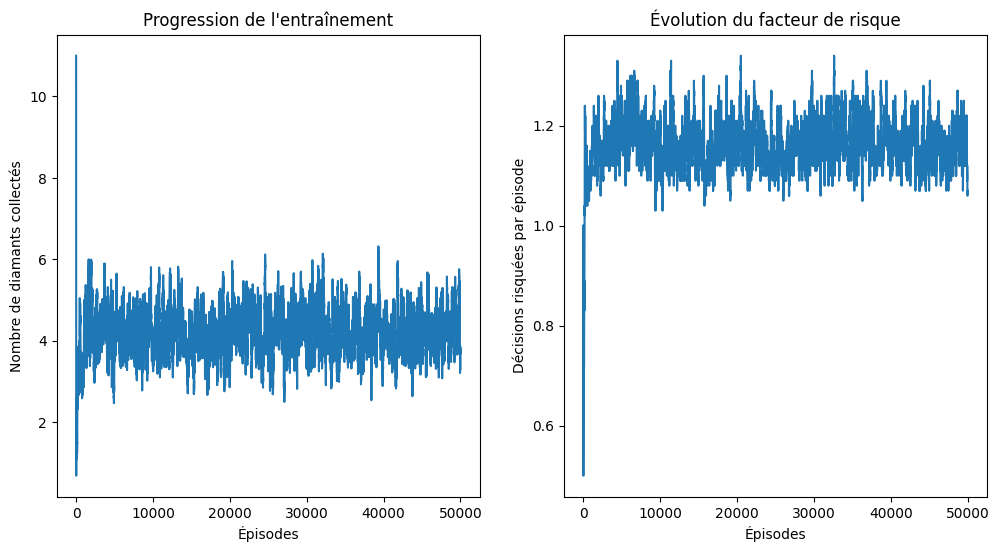

In [10]:
# Fonction permettant de lancer l'entrainement
def start():
    rewards, risk_taken, trained_agent = train_agent(50000, state_dim, action_dim, epsilon_start, epsilon_end, epsilon_decay)

    # Sauvegarde du modèle
    torch.save(trained_agent.model, 'diamant_model.pth')

    # Traitement des récompenses pour affichage
    rewards = pd.Series(rewards)
    rewards = rewards.rolling(100, min_periods=1).mean()

    # Traitement du facteur de risque pour affichage
    risk_taken = pd.Series(risk_taken)
    risk_taken = risk_taken.rolling(100, min_periods=1).mean()

    # Création du graphique
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title('Progression de l\'entraînement')
    plt.xlabel('Épisodes')
    plt.ylabel('Nombre de diamants collectés')

    plt.subplot(1, 2, 2)
    plt.plot(risk_taken)
    plt.title('Évolution du facteur de risque')
    plt.xlabel('Épisodes')
    plt.ylabel('Décisions risquées par épisode')

    # Affichage du graphique
    plt.show()

start()